# Proportion analysis using scanpro

A notebook to test the scanpro tool.

The dataset used in this tutorial is a simulated dataset with three conditions and five cell clusters. The proportions of these clusters do not change significantly across conditions.

In [1]:
import anndata as ad
import numpy as np

from scanpro import scanpro, anova, t_test
from scanpro.linear_model import create_design
from scanpro.get_transformed_props import get_transformed_props

In [2]:
# Set seed to make simulations reproducible
np.random.seed(1)

-------------

## Load anndata

In [3]:
adata = ad.read_h5ad('scanpro_tutorial.h5ad')
adata

AnnData object with n_obs × n_vars = 37079 × 10
    obs: 'sample', 'cluster', 'group'

The anndata.obs table has to include 3 columns, for example:
  - sample
  - biological condition / group
  - clusters/celltypes

In [4]:
adata.obs

,sample,cluster,group
cells,,,
cell_1,S1,c1,cond_1
cell_2,S1,c1,cond_1
cell_3,S1,c1,cond_1
cell_4,S1,c1,cond_1
cell_5,S1,c1,cond_1
...,...,...,...
cell_37075,S6,c5,cond_3
cell_37076,S6,c5,cond_3
cell_37077,S6,c5,cond_3


--------------

## Run scanpro
* You can use the wrapper function "scanpro". 
* Parameters are:
    - anndata object
    - clusters: name of clusters/celltypes column in obs table
    - sample: name of sample column in obs table
    - cond: name of condition/group column in obs table
    - transform: type of transformation; logit or arcsin, default is logit

In [5]:
out = scanpro(adata, clusters_col='cluster', samples_col='sample', conds_col='group', transform='logit')

out.results

There are more than 2 conditions. ANOVA will be performed...
Done!


,baseline_props,mean_props_cond_1,mean_props_cond_2,mean_props_cond_3,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
c1,0.409531,0.006399,0.007605,0.010391,1.015703,0.362148,0.452685
c2,0.374093,0.043683,0.075932,0.043750,1.907890,0.148393,0.370983
c3,0.156935,0.137301,0.157528,0.184273,0.503052,0.604682,0.604682
c4,0.051161,0.401103,0.270136,0.415870,2.019649,0.132702,0.370983
c5,0.008280,0.411515,0.488800,0.345716,1.347237,0.259957,0.433262


* the `scanpro` function generates a ScanproResult object that has the following methods:
    - results: returns the results as a dataframe
    - props: returns clusters proportions as a dataframe
    - prop_trans: returns transformed proportions as a dataframe
    - counts: returns counts as a dataframe
    - design: returns the design matrix
    - plot and plot_samples: for plotting

In [6]:
out.props

cluster,c1,c2,c3,c4,c5
sample,,,,,
S1,0.005436,0.063044,0.150121,0.388767,0.392632
S2,0.007362,0.024321,0.124481,0.413438,0.430398
S3,0.010331,0.055854,0.097744,0.241583,0.594487
S4,0.004880,0.096009,0.217312,0.298688,0.383112
S5,0.010221,0.041330,0.202284,0.434774,0.311391
S6,0.010562,0.046169,0.166261,0.396966,0.380042


-----------

## Visualisation of proportions for each condition in each cluster
* You can plot proportion per condition using `out.plot()` function. Parameters are:
    - kind: kind of plot: `stripplot`, `barplot` or `boxplot`
    - clusters: specify which clusters you want to plot, default is all
    - save: path to where you want to save the plot
* or `out.plot_samples()` to plot a bar plot of proportions of clusters in samples. Parameters are:
    - stacked: True for stacked bar plot
    - x: Whether samples or clusters should be on the x axis
    - save: path to where you want to save the plot

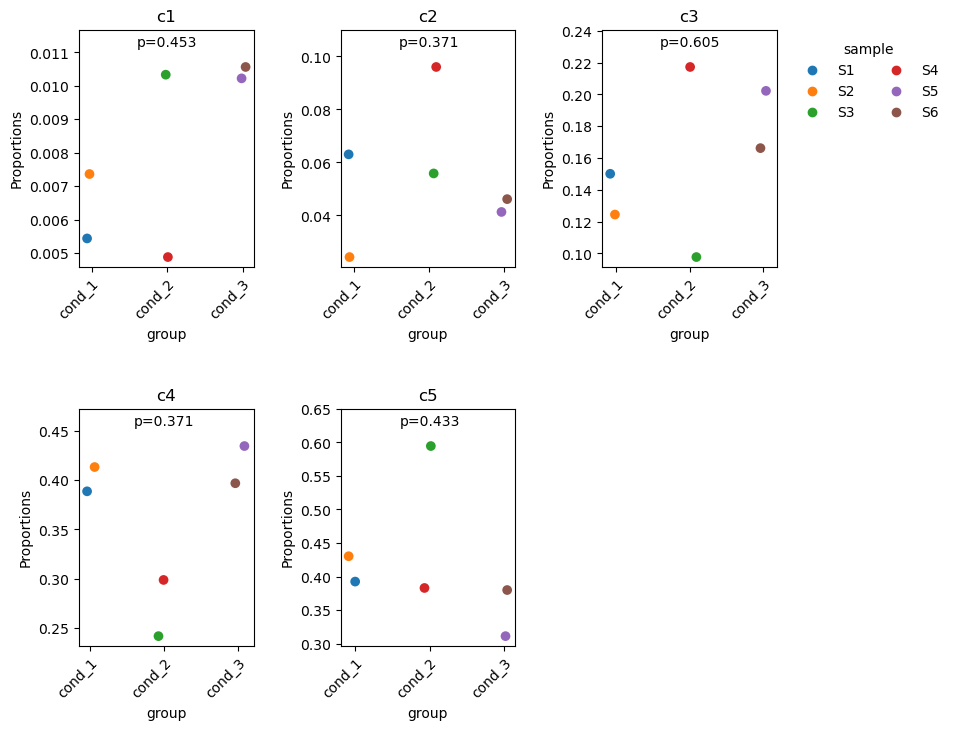

In [7]:
out.plot()

* You can use `kind` to set different styles for the plot:

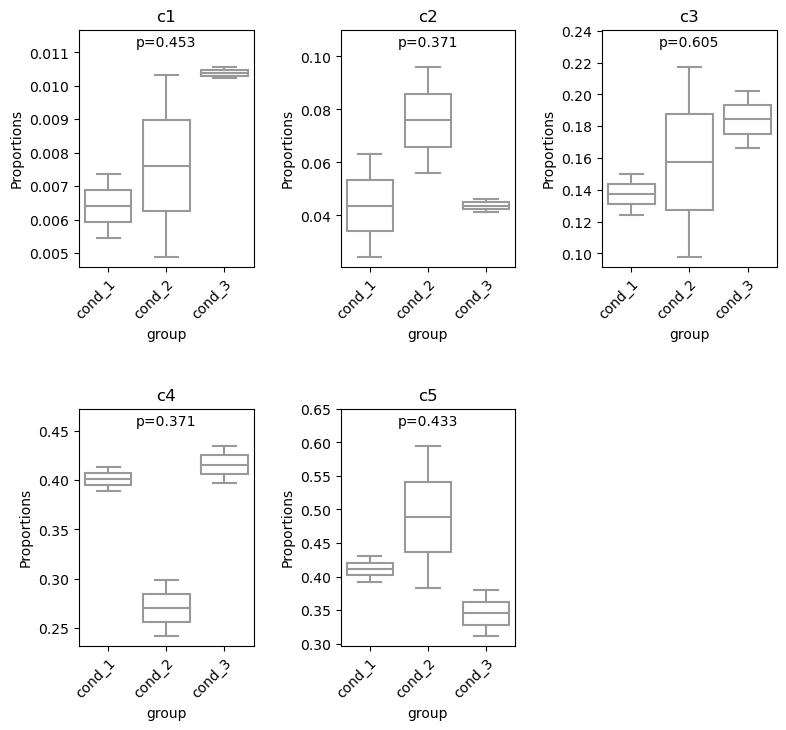

In [8]:
out.plot(kind="boxplot")

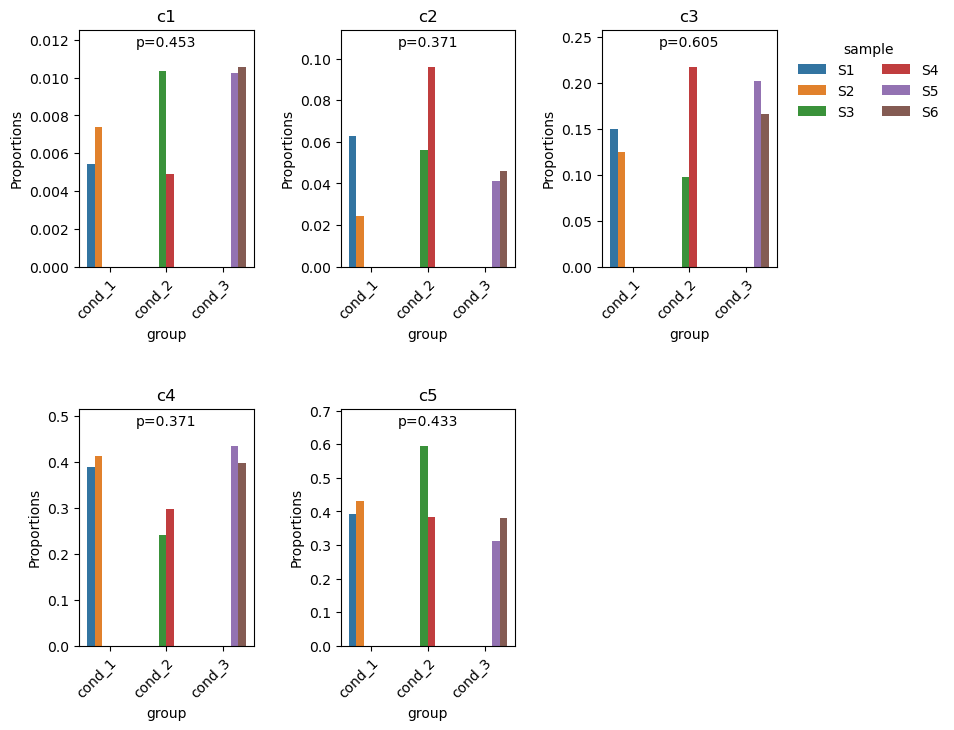

In [9]:
out.plot(kind="barplot")

* You can use `clusters` to limit the clusters shown:

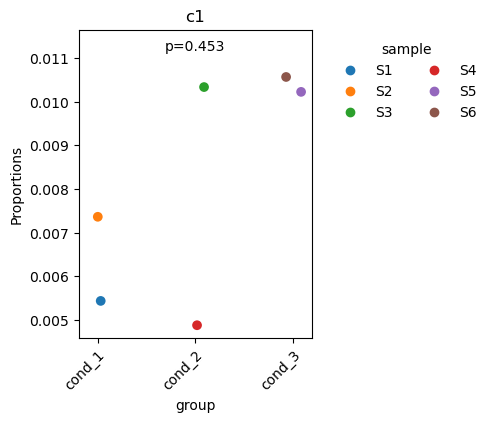

In [10]:
out.plot(clusters=["c1"])

* Proportions of cells per sample can be plotted with `plot_samples`:

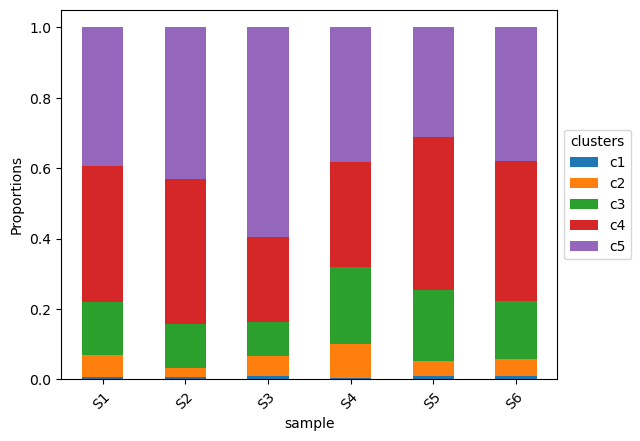

In [11]:
out.plot_samples(stacked=True)

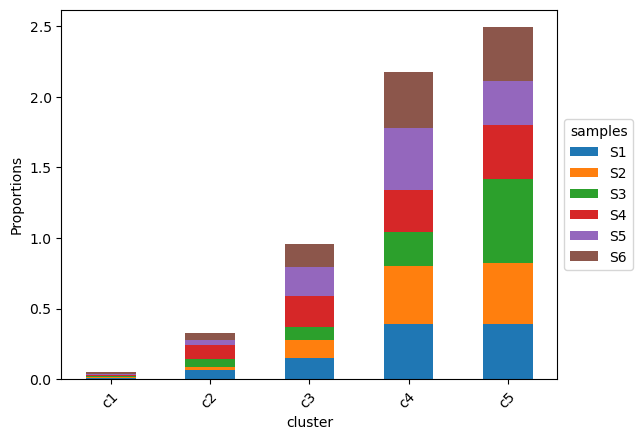

In [12]:
out.plot_samples(x="clusters")

------

## Test specific conditions
* by using the parameter `conditions` you can specify conditions of interests you want to compare instead of comparing all the conditions

In [13]:
out = scanpro(adata, clusters_col='cluster', samples_col='sample',
              conds_col='group', transform='logit', conditions=['cond_1', 'cond_2'])

out.results

There are 2 conditions. T-Test will be performed...
Done!


,baseline_props,mean_props_cond_1,mean_props_cond_2,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
c1,0.409531,0.006399,0.007605,0.841368,-0.346112,0.734065,0.806602
c2,0.374093,0.043683,0.075932,0.575292,-1.821747,0.088493,0.299088
c3,0.156935,0.137301,0.157528,0.871598,-0.249180,0.806602,0.806602
c4,0.051161,0.401103,0.270136,1.484819,1.650414,0.119635,0.299088
c5,0.008280,0.411515,0.488800,0.841889,-0.858832,0.403949,0.673249


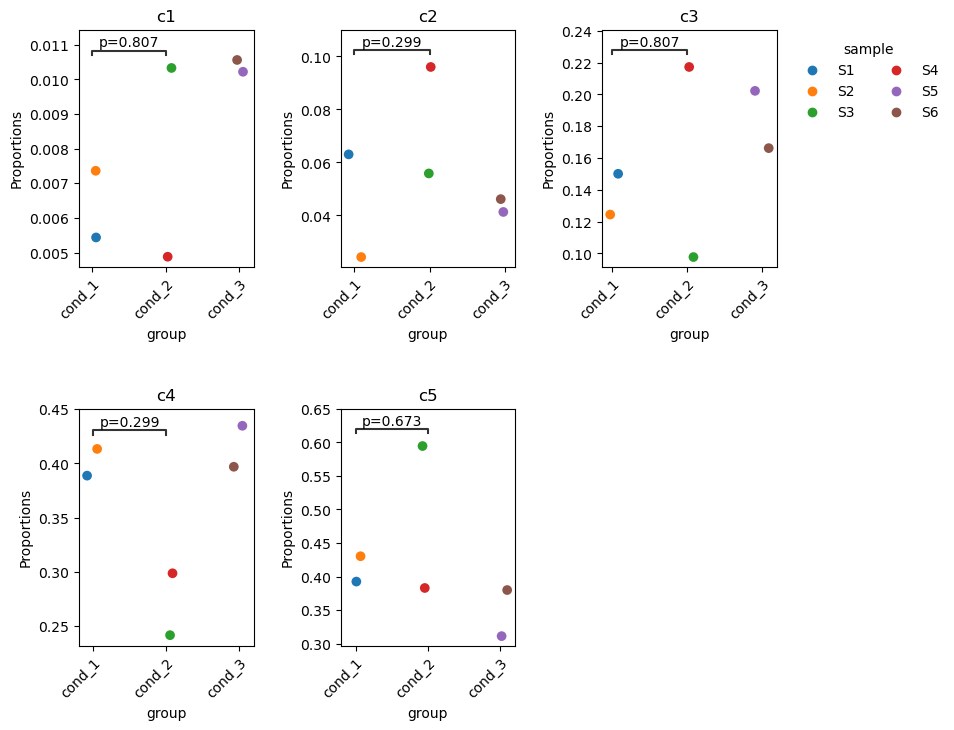

In [14]:
out.plot()

---------------

## Bootstrapping method
* The bootstrapping method splits the original samples into `n_reps` replicated and run the analysis on the simulated samples.
* The bootstrapping method will run for non-replicated datasets in the following scenarios:
    - If the number of samples in samples_col is equal to the number of conditions in conds_col
    - If samples_col is not given or set to None, the dataset is assumed to be not replicated 
    and scanpro will run the bootstrapping method by setting conds_col temporarily as samples_col

In [15]:
out_boot = scanpro(adata,
                   clusters_col='cluster',
                   conds_col='group',
                   # no sample column given,
                   transform='arcsin',
                   n_reps=8,  # number of replicates generated by bootstrapping
                   conditions=['cond_1', 'cond_2']  # optional: you can also specify conditions, or test all of them
                   )

out_boot.results

Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
Simulation may take some minutes...
Generating 8 replicates and running 100 simulations...
Finished 100 simulations in 10.57 seconds


,baseline_props,mean_props_cond_1,mean_props_cond_2,p_values
clusters,,,,
c1,0.409531,0.006574,0.013976,0.657169
c2,0.374093,0.045318,0.073735,0.429444
c3,0.156935,0.138966,0.143901,0.596598
c4,0.051161,0.402073,0.256700,0.110951
c5,0.008280,0.407068,0.511688,0.218473


* To plot the bootstrapping results, use the `plot` function

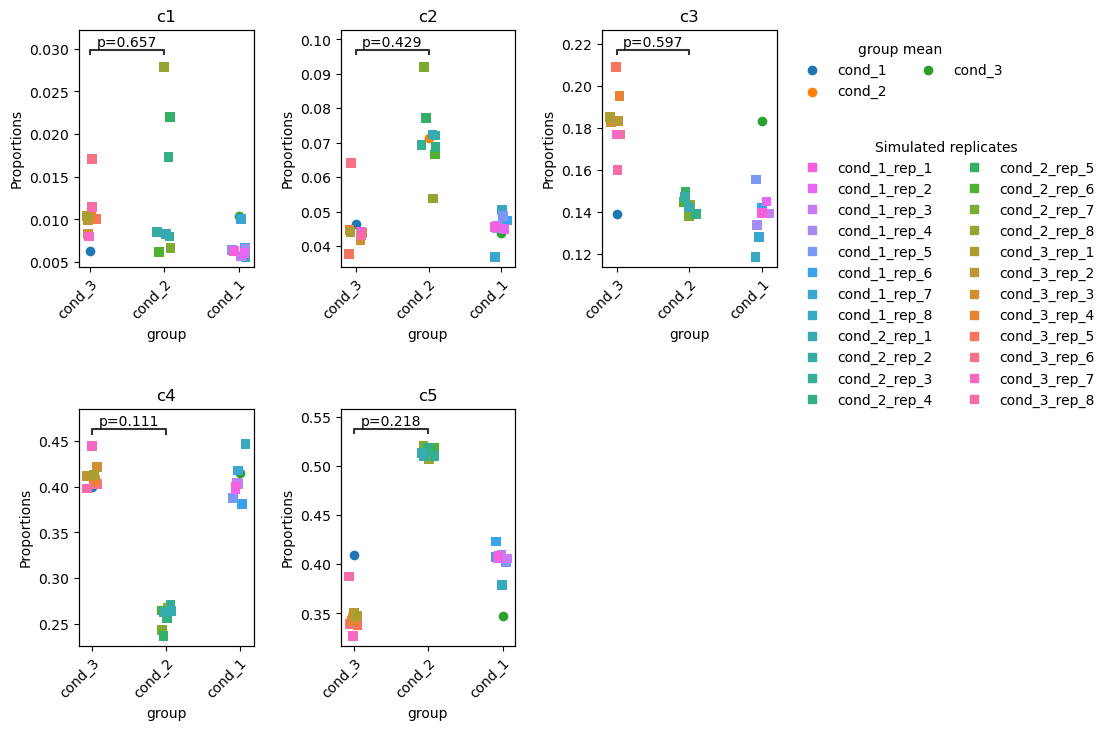

In [16]:
out_boot.plot()

------------------

## Partially replicated data

We now imagine that the cond_1 dataset was not replicated. This will trigger a partial bootstrapping method.

In [17]:
adata_partial = adata.copy()
adata_partial.obs.loc[adata_partial.obs["group"] == "cond_1", "sample"] = "S1"

In [18]:
out_boot = scanpro(adata_partial,
                   clusters_col='cluster',
                   conds_col='group',
                   samples_col='sample',
                   transform='arcsin',
                   n_reps=8,
                   conditions=['cond_1', 'cond_2']
                   )

out_boot.results

The following conditions don't have replicates: cond_1
Both normal scanpro and sim_scanpro will be performed.
Running scanpro with original replicates...
There are 2 conditions. T-Test will be performed...
Done!
Running scanpro with simulated replicates...
Generating 8 replicates and running 100 simulations...
Finished 100 simulations in 10.59 seconds
To access results for original replicates, run <out.results>, and <out.sim_results> for simulated results


,baseline_props,mean_props_cond_1,mean_props_cond_2,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
c1,0.409531,0.006264,0.007605,0.823593,-0.123120,0.906333,0.906333
c2,0.374093,0.046387,0.075932,0.610909,-0.999106,0.359144,0.743984
c3,0.156935,0.139092,0.157528,0.882967,-0.233504,0.823712,0.906333
c4,0.051161,0.399380,0.270136,1.478442,2.325340,0.062309,0.311547
c5,0.008280,0.408877,0.488800,0.836493,-0.819015,0.446390,0.743984


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


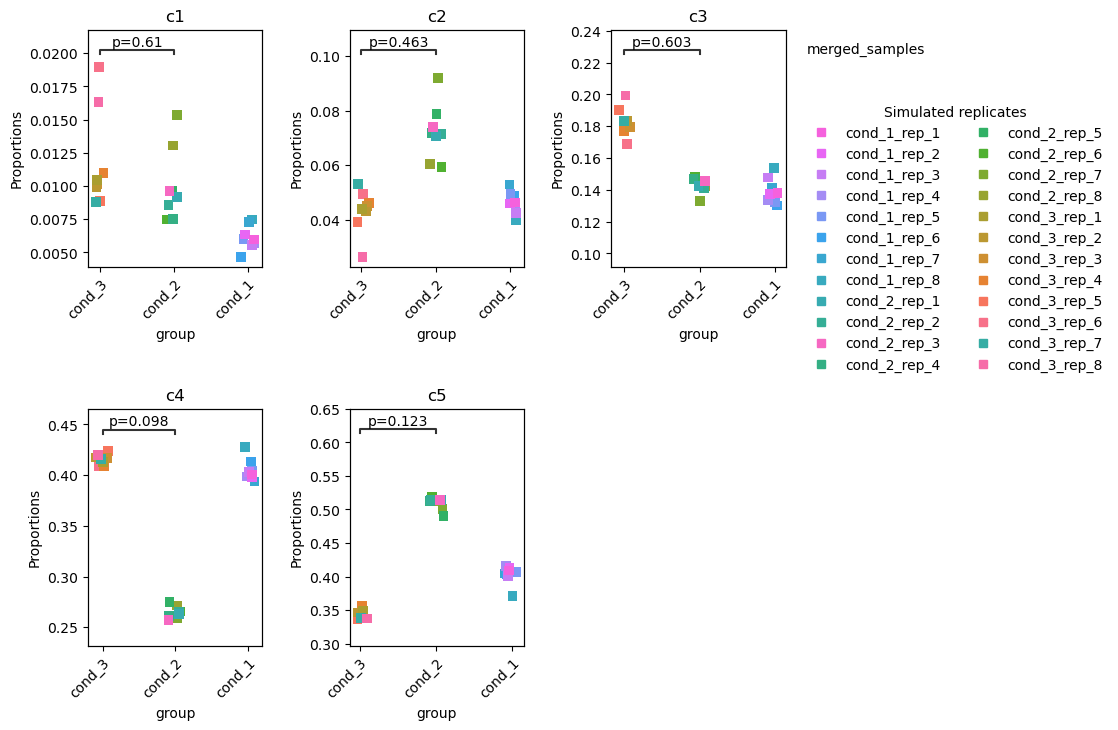

In [20]:
out_boot.plot()

-----------

## Scanpro workflow

The scanpro function is a wrapper function, to have more controls you can perform the steps below and see how the scanpro
function works

* Get proportions and transformed proportions using `get_transformed_props` function

In [21]:
counts, props, prop_trans = get_transformed_props(adata, sample_col='sample', cluster_col='cluster', transform='logit')

In [22]:
counts

cluster,c1,c2,c3,c4,c5
sample,,,,,
S1,45,522,1243,3219,3251
S2,46,152,778,2584,2690
S3,54,292,511,1263,3108
S4,16,315,713,980,1257
S5,68,275,1346,2893,2072
S6,78,341,1228,2932,2807


In [23]:
props

cluster,c1,c2,c3,c4,c5
sample,,,,,
S1,0.005436,0.063044,0.150121,0.388767,0.392632
S2,0.007362,0.024321,0.124481,0.413438,0.430398
S3,0.010331,0.055854,0.097744,0.241583,0.594487
S4,0.004880,0.096009,0.217312,0.298688,0.383112
S5,0.010221,0.041330,0.202284,0.434774,0.311391
S6,0.010562,0.046169,0.166261,0.396966,0.380042


In [24]:
prop_trans

cluster,c1,c2,c3,c4,c5
sample,,,,,
S1,-5.198679,-2.698113,-1.733536,-0.452733,-0.436502
S2,-4.893820,-3.688879,-1.950396,-0.350114,-0.280595
S3,-4.553587,-2.826251,-2.222005,-1.144124,0.381781
S4,-5.288267,-2.241485,-1.281479,-0.853905,-0.476938
S5,-4.566171,-3.142492,-1.372083,-0.262750,-0.793816
S6,-4.533900,-3.027010,-1.612283,-0.418396,-0.489623


In [25]:
# proportions of each cluster in all samples
baseline_props = adata.obs['cluster'].value_counts()/adata.obs.shape[0]
baseline_props

cluster
c5    0.409531
c4    0.374093
c3    0.156935
c2    0.051161
c1    0.008280
Name: count, dtype: float64

* Create design matrix using `create_design` function. The matrix has samples as rows and conditions and columns, whith 1s and 0s to specify which condition belongs to which sample (independent variables). The design matrix will be used as the X matrix in the linear model fit.
* Parameters:
    - data: anndata object, or a pandas dataframe
    - samples: name of samples column
    - conds: name of conditions/groups column

In [26]:
design = create_design(data=adata, samples='sample', conds='group')
design

group,cond_1,cond_2,cond_3
sample,,,
S1,1,0,0
S2,1,0,0
S3,0,1,0
S4,0,1,0
S5,0,0,1
S6,0,0,1


In [27]:
# for anova -> more than 2 conditions/groups
# The coef parameter specify the columns in the design matrix containing conditions of interest
# that you want to compare
coef = np.arange(len(design.columns))
coef

array([0, 1, 2])

* Since we have more than 2 conditions, use the function `anova` to compare. If you have two conditions or want to only compare two, then specify a contras variable `cont = [1, -1]` with 1 and -1 match the columns of the design matrix with two conditions you want to compare. if the design matrix has more than two conditions but you only want to compare two, put 1 and -1 where they match the columns of interest and fill the rest with 0s, in this case, to compare 10x and celseq: `cont = [1, -1, 0]`

In [28]:
anova(props, prop_trans, design, coef, robust=True)

,mean_props_cond_1,mean_props_cond_2,mean_props_cond_3,f_statistics,p_values,adjusted_p_values
clusters,,,,,,
c1,0.006399,0.007605,0.010391,1.015703,0.362148,0.452685
c2,0.043683,0.075932,0.043750,1.907890,0.148393,0.370983
c3,0.137301,0.157528,0.184273,0.503052,0.604682,0.604682
c4,0.401103,0.270136,0.415870,2.019649,0.132702,0.370983
c5,0.411515,0.488800,0.345716,1.347237,0.259957,0.433262


* Additionally, you can specify cofactors of interest and add them to the design matrix, either specify cofactor columns in the adata.obs as parameter `cofactor` to the `create_design` function, or add it manually to the design matrix. In our case, we will add pair information that specifies which sample is a replicate

In [29]:
X = design.iloc[:,coef]
N = len(X)  # number of samples
p = len(X.columns)  # number of conditions

In [30]:
# add pair information to the design matrix as cofactor
cont = np.tile([1, 2], N//2)
new_design = design.copy()
new_design['pair'] = cont
new_design

group,cond_1,cond_2,cond_3,pair
sample,,,,
S1,1,0,0,1
S2,1,0,0,2
S3,0,1,0,1
S4,0,1,0,2
S5,0,0,1,1
S6,0,0,1,2


In [31]:
# run anova, taking into account pair information
anova(props, prop_trans, new_design, coef, robust=True)

,mean_props_cond_1,mean_props_cond_2,mean_props_cond_3,f_statistics,p_values,adjusted_p_values
clusters,,,,,,
c1,0.006399,0.007605,0.010391,0.719279,0.487104,0.608879
c2,0.043683,0.075932,0.043750,1.351087,0.258959,0.608879
c3,0.137301,0.157528,0.184273,0.356240,0.700304,0.700304
c4,0.401103,0.270136,0.415870,1.430231,0.239254,0.608879
c5,0.411515,0.488800,0.345716,0.954057,0.385175,0.608879


In [32]:
# to compare only cond_1 and cond_2, specify a contrast and run t_test
contr = [1,-1,0]
t_test(props, prop_trans, design, contr, robust=True)

,mean_props_cond_1,mean_props_cond_2,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,
c1,0.006399,0.007605,0.841368,-0.346112,0.734065,0.806602
c2,0.043683,0.075932,0.575292,-1.821747,0.088493,0.299088
c3,0.137301,0.157528,0.871598,-0.249180,0.806602,0.806602
c4,0.401103,0.270136,1.484819,1.650414,0.119635,0.299088
c5,0.411515,0.488800,0.841889,-0.858832,0.403949,0.673249
